# hw1

I didn't realize until after I had tried to do all the questions that we only needed to do one...

By the way, I don't know if it's possible to get the ROSAT pictures anymore. The website seems well and truly defunct.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy import constants as const
from astropy import coordinates as coord
from matplotlib.ticker import MultipleLocator

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.top'] = True
plt.rcParams['xtick.major.bottom'] = True
plt.rcParams['xtick.minor.top'] = True
plt.rcParams['xtick.minor.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.major.left'] = True
plt.rcParams['ytick.major.right'] = True
plt.rcParams['ytick.minor.left'] = True
plt.rcParams['ytick.minor.right'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

## #1

Here are the objects I picked:
- STAR https://skyserver.sdss.org/dr18/VisualTools/quickobj?sId=4206556203244083200
- GALAXY https://skyserver.sdss.org/dr18/VisualTools/quickobj?objId=1237648720693755918
- QSO -- I used the SkyServer SQL Search for quasars by spectroscopy, then pulled up the "Quick Look" for the object IDs for about 10 of them. Every time, trying to download the spectrum as a FITS file threw a 500 Internal Server Error. I'm not sure what to do about this...

### star

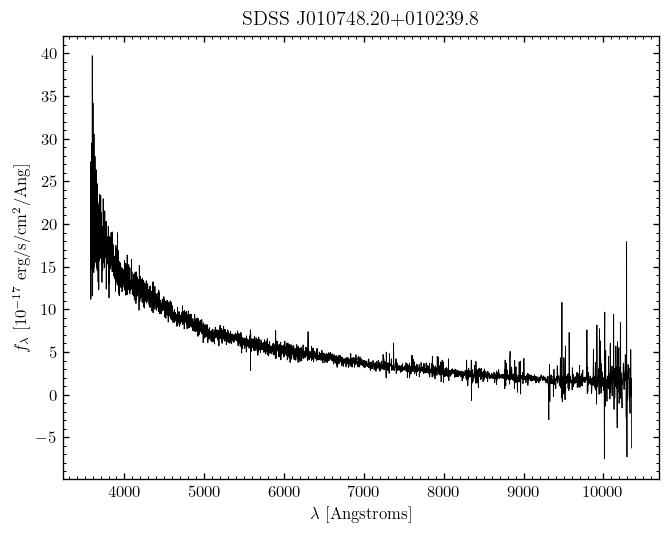

In [3]:
spec = fits.getdata('spec-3736-55214-0706.fits')
loglam = spec['loglam']
flux   = spec['flux']

fig, ax = plt.subplots()
ax.plot(10 ** loglam, flux, lw=0.5, color='black')
ax.set_xlabel(r'$\lambda$ [Angstroms]')
ax.set_ylabel(r'$f_\lambda$ [$10^{-17}$ erg/s/cm$^2$/Ang]')

ax.set_title('SDSS J010748.20+010239.8')

ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(100))

ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.show()

### galaxy

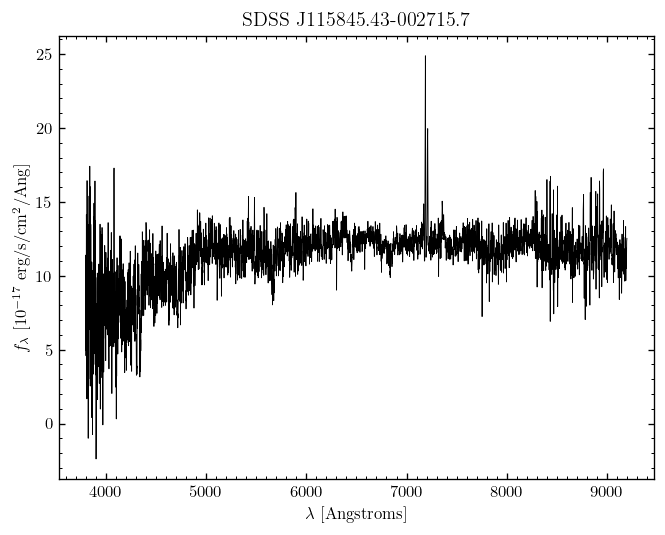

In [4]:
spec = fits.getdata('spec-0285-51930-0184.fits')
loglam = spec['loglam']
flux   = spec['flux']

fig, ax = plt.subplots()
ax.plot(10 ** loglam, flux, lw=0.5, color='black')
ax.set_xlabel(r'$\lambda$ [Angstroms]')
ax.set_ylabel(r'$f_\lambda$ [$10^{-17}$ erg/s/cm$^2$/Ang]')
ax.set_title('SDSS J115845.43-002715.7')

ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(100))

ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.show()

### qso

could not get a spectrum to download

### conversion to frequency

Now let's work out the conversion to flux density $f_\nu$.

We know that flux density is related to specific intensity by
$$
f_{ \{ \lambda, \nu \} } = \int \mathrm{d}\Omega \ I_{ \{ \lambda, \nu \} } \cos\theta.
$$

We also know that the specific intensities are related by
$$
I_\lambda = \frac{c}{\lambda^2} I_\nu(\nu = c/\lambda)
$$

Integrating both sides of this relation gives
$$
\begin{aligned}
\int \mathrm{d}\Omega \ I_\lambda \cos\theta
&= \int \mathrm{d}\Omega \ \frac{c}{\lambda^2} I_\nu(\nu = c/\lambda) \cos\theta \\
f_\lambda(\lambda) &= \frac{c}{\lambda^2} f_\nu(\nu = c/\lambda)
\end{aligned}
$$

Now let's implement this for our galaxy spectrum.

erg / (cm2 Hz s)


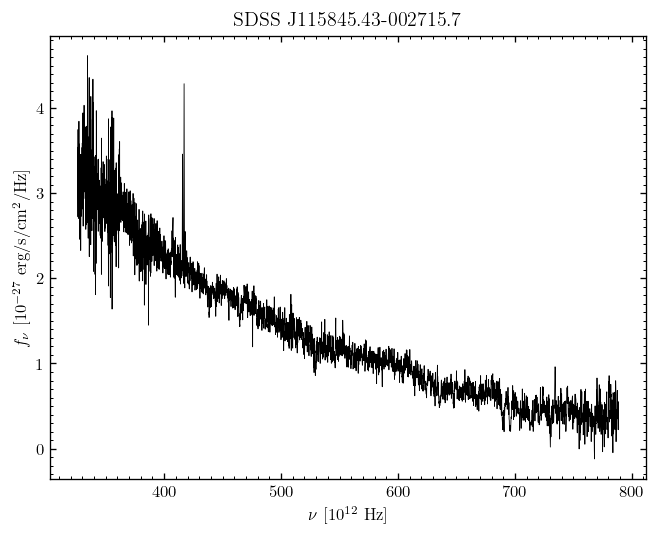

In [5]:
spec = fits.getdata('spec-0285-51930-0184.fits')
loglam = spec['loglam']
flux   = spec['flux']

lam = 10 ** loglam * u.Angstrom
f_lam = flux * 1e-17 * u.erg / u.s / u.cm**2 / u.Angstrom

nu = (const.c / lam).to(u.Hz)
f_nu = lam**2 / const.c * f_lam
f_nu = f_nu.to(u.erg / u.s / u.cm**2 / u.Hz)

print(f_nu.unit)

fig, ax = plt.subplots()
ax.plot(nu * 1e-12, f_nu * 1e27, lw=0.5, color='black')
ax.set_xlabel(r'$\nu$ [$10^{12}$ Hz]')
ax.set_ylabel(r'$f_\nu$ [$10^{-27}$ erg/s/cm$^2$/Hz]')
ax.set_title('SDSS J115845.43-002715.7')

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(10))

ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
plt.show()

### gaussian smoothing

Now let's smooth this with a Gaussian corresponding to $R = 1000$. Recall that $R \equiv \lambda / \Delta \lambda$, where $\Delta \lambda$ is the FWHM of our Gaussian. (And note that the FWHM of a Gaussian with standard deviation $\sigma$ is $2 \sqrt{2 \ln 2} \sigma$, according to [Wikipedia](https://en.wikipedia.org/wiki/Full_width_at_half_maximum).) So, at a given $\lambda$, we need

$$
\sigma = \Delta \lambda / (2 \sqrt{2 \ln 2}) = \lambda / (2000 \sqrt{2 \ln 2}).
$$

I remember in class something about how the filter is constant if you do this in $\log \lambda$, but I can't quite wrap my head around that, so here's a more head-on interpretation of the question.

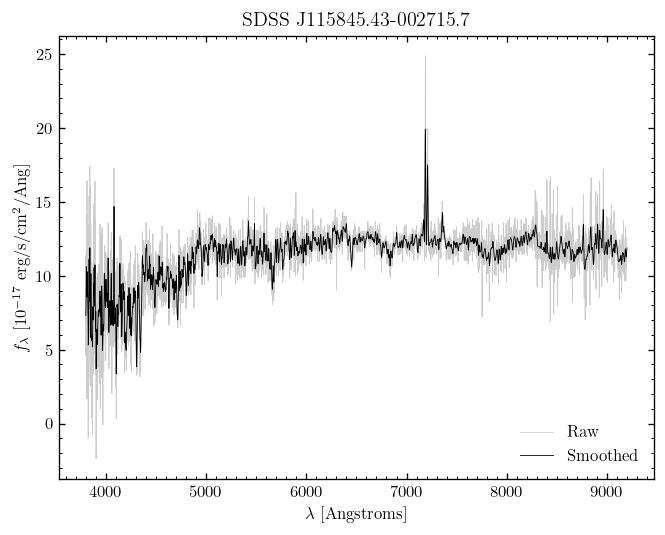

In [6]:
spec = fits.getdata('spec-0285-51930-0184.fits')
loglam = spec['loglam']
lam = 10 ** loglam
flux   = spec['flux']

R = 1000

DENOM = 2 * R * np.sqrt(2 * np.log(2))
def desired_sigma(lam):
    return lam / DENOM

ROOT_2PI = np.sqrt(2 * np.pi)
def gaussian(x, mu, sigma):
    return 1 / (ROOT_2PI * sigma) * np.exp(- 0.5 * (x - mu)**2 / sigma**2)

window_size = 11  # must be odd
pad_lam = np.pad(lam, window_size // 2, mode='constant', constant_values=0)
pad_flux = np.pad(flux, window_size // 2, mode='constant', constant_values=0)

smoothed = np.zeros((len(lam)))
for i in range(len(lam)):
    sig = desired_sigma(lam[i])
    lams = pad_lam[i:i+window_size]
    filt = gaussian(lams, lam[i], sig)
    smoothed[i] = (filt * pad_flux[i:i+window_size]).sum() / filt.sum()

fig, ax = plt.subplots()
ax.plot(lam, flux, lw=0.5, color=(0,0,0,0.2))
ax.plot(lam, smoothed, lw=0.5, color='black')
ax.set_xlabel(r'$\lambda$ [Angstroms]')
ax.set_ylabel(r'$f_\lambda$ [$10^{-17}$ erg/s/cm$^2$/Ang]')
ax.set_title('SDSS J115845.43-002715.7')
ax.legend(['Raw', 'Smoothed'], loc='lower right', frameon=False)

ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(100))

ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.show()

Compare this to ![](spec-0285-51930-0184.jpeg)

## #4

First, let's download the data. I'm not sure which data file we want so I'll just grab all of the natural moments.

In [7]:
import requests
from os.path import exists

base_url = "https://www2.mpia-hd.mpg.de/THINGS/Data_files"

for moment in range(3):
    file_name = f"NGC_2403_NA_MOM{moment}_THINGS.FITS"
    url = f"{base_url}/{file_name}"

    if exists(file_name):
        print(f'{file_name} found')
        continue

    # https://stackoverflow.com/a/16696317
    with requests.get(url, stream=True) as req:
        req.raise_for_status()
        with open(file_name, "wb") as f:
            for chunk in req.iter_content(chunk_size=8192): 
                f.write(chunk)

    print(f"downloaded {file_name}")

NGC_2403_NA_MOM0_THINGS.FITS found
NGC_2403_NA_MOM1_THINGS.FITS found
NGC_2403_NA_MOM2_THINGS.FITS found


These files contain what are basically just the images from Figure 11 of the [THINGS paper](https://arxiv.org/pdf/0810.2125). I want to reproduce their figure, including getting the RA and Dec values for the pixel indices. Below is my attempt to reverse engineer their axes based on some data in the headers of the FITS files. I am only checking the result by eye, so this may be wrong.

In [8]:
# I'm trying to figure out how to get the RA, DEC values for the pixels
head = fits.getheader('NGC_2403_NA_MOM1_THINGS.FITS')
ra_indices = np.arange(head['NAXIS1']) - head['CRPIX1']
ra_vals = head['CRVAL1'] + 2 * head['CDELT1'] * ra_indices
#                          ^ don't know why I need to put 2 here, 
#                            but it makes it match the figure in the paper

dec_indices = np.arange(head['NAXIS2']) - head['CRPIX2']
dec_vals = head['CRVAL2'] + head['CDELT2'] * dec_indices

# stealing the ticks from the figure in the paper
ra_ticks = coord.Angle(['7h39m', '7h38m', '7h37m', '7h36m', '7h35m']).to(u.deg)
ra_ticklabels = [
    '$39^\mathrm{m}$',
    '$38^\mathrm{m}$',
    '$37^\mathrm{m}$',
    '$7^\mathrm{h} 36^\mathrm{m}$',
    '$35^\mathrm{m}$',
]

dec_ticks = coord.Angle(['65d28m', '65d36m', '65d44m']).to(u.deg)
dec_ticklabels = [
    r"$28'$",
    r"$65^\circ 36'$",
    r"$44'$"
]

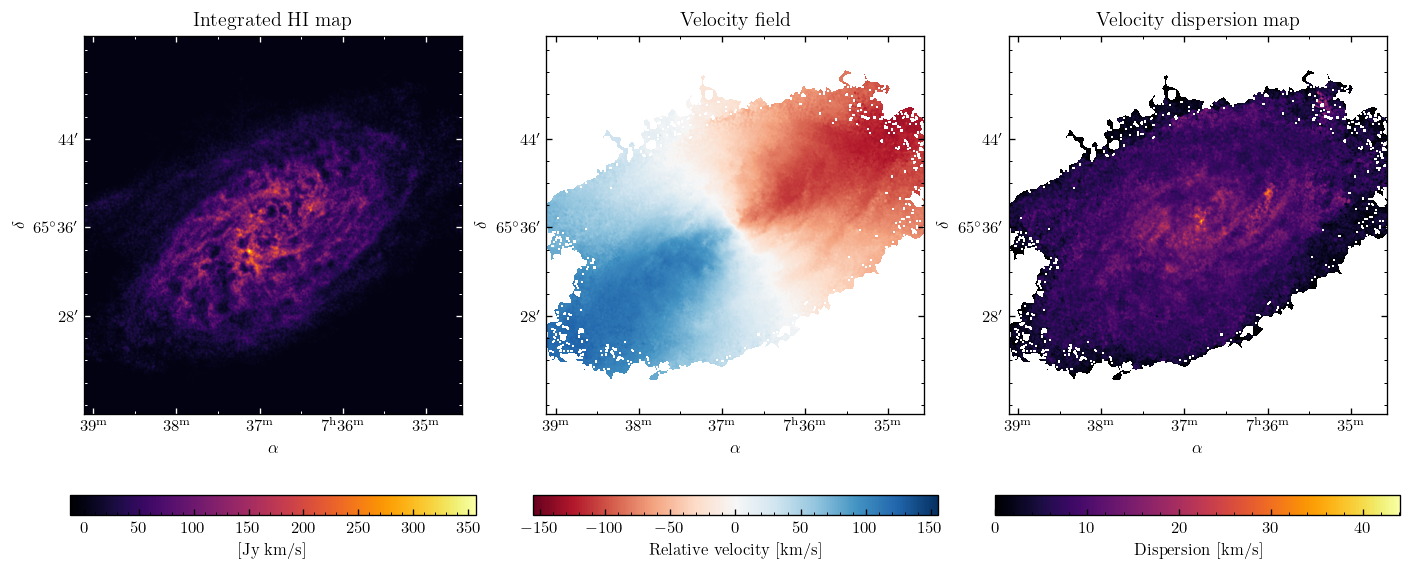

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

kw = dict(origin='lower',  # for naturalness
          extent=(ra_vals[0], ra_vals[-1], dec_vals[0], dec_vals[-1]),  # use the RA and Dec values for the axes that we calculated
          aspect=abs(ra_vals[-1] - ra_vals[0]) / abs(dec_vals[-1] - dec_vals[0]))  # make the plot square

titles = ['Integrated HI map', 'Velocity field', 'Velocity dispersion map']
cb_labels = ['[Jy km/s]', 'Relative velocity [km/s]', 'Dispersion [km/s]']


for i in range(3):
    ax = axs[i]

    x = fits.getdata(f'NGC_2403_NA_MOM{i}_THINGS.FITS')
    x = x.squeeze()

    if i == 1:
        x /= 1e3  # convert to km/s
        
        v_sys = 133.1  # from THINGS paper, table 1
        diff = x - v_sys
        vlim = np.nanmax(np.abs(diff))

        im = ax.imshow(diff, vmin=-vlim, vmax=+vlim, cmap='RdBu', **kw)

    else:
        if i == 2:
            x /= 1e3  # convert to km/s
        
        im = ax.imshow(x, cmap='inferno', **kw)

    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\delta$')
    ax.set_title(titles[i])
    
    ax.set_xticks(ra_ticks.value)
    ax.set_xticklabels(ra_ticklabels)
    ax.set_yticks(dec_ticks.value)
    ax.set_yticklabels(dec_ticklabels)
    ax.xaxis.set_minor_locator(MultipleLocator(abs(ra_ticks[1] - ra_ticks[0]).value / 2))
    ax.yaxis.set_minor_locator(MultipleLocator(abs(dec_ticks[1] - dec_ticks[0]).value / 4))
    if i == 0:
        ax.tick_params(axis='both', which='both', color='white')

    fig.colorbar(im, label=cb_labels[i], ax=ax, location='bottom', shrink=0.5)

fig.tight_layout(w_pad=-20)
plt.show()

This looks like a pretty good match of Figure 11!

I'm not sure what exactly is meant by

> estimate its rotation velocity at the furthest measurable points

(specifically how 'rotation velocity' is defined), so I'm going to hazard a guess that we want to use the relative velocity at the extents of the galaxy in velocity field to get an angular speed (in units of rad/s or similar).

Let's first eyeball the angular size of the galaxy: looks like around $2^\mathrm{m}$ in RA and about $10'$ in dec. At these distances, we see a maximum relative velocity of around 150 km/s at these angular distances.

In the paper, Table 1 tells us that NGC2403 has an optical size of $2.20$ in units of $\log(0.1')$, which we can convert into degrees as

In [10]:
theta = (10 ** 2.20) * (0.1 * u.arcmin)
print(np.around(theta, 1))

theta = theta.to(u.deg)
print(np.around(theta, 3))

15.8 arcmin
0.264 deg


This looks pretty comparable to something like our $\sim 2'$ in RA, $\sim 10'$ in dec if they were added in quadrature, so let's take this value.

Table 1 also gives us a distance estimate of 3.2 Mpc. Let's take this to be an angular diameter distance $D_A$. We can combine this with our angular size $\theta$ to get an estimate for the radius of the galaxy of $s = D_A \ \theta = (3.2 \ \mathrm{Mpc}) \theta$, which is

In [11]:
R = (3.2 * u.Mpc * theta.to(u.rad).value).to(u.kpc)
print(np.around(R, 1))

14.8 kpc


So we have 150 km/s at 15 kpc, which yields an angular speed by $\omega = v / r$ equal to

In [12]:
print(np.around(((150 * u.km/u.s) / (15 * u.kpc) * u.rad).to(u.rad / u.Gyr), 1))

10.2 rad / Gyr


So we have an answer. I have an issue, though, which is that I feel like I haven't at all accounted for the angle between the plane of the galaxy and the plane of the sky. I just took the relative velocity in the outskirts of the disk, but I feel like there is some component of this relative velocity which corresponds just to keeping the stars in the disk plane. Is there a way to handle this? In principle for this estimate, we'd like the galaxy to be edge-on, so that we'd know the relative velocity of the outskirts is exactly along the tangential direction.

Also, just because I'm curious: how different are the luminosity and angular diameter distances for something this far away? Let's use the default cosmology in astropy and find out.

using Planck18 cosmology...
redshift estimates:
  using angular diameter distance, redshift estimate is 7.2285e-04
  using luminosity distance, redshift estimate is 7.2181e-04


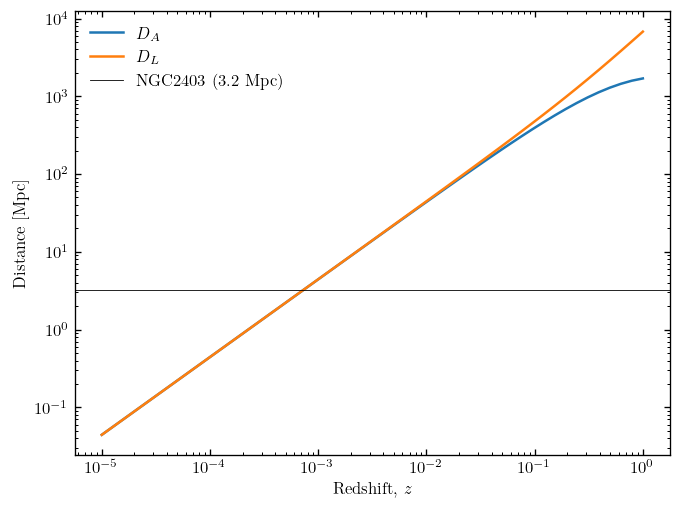

In [13]:
from astropy import cosmology as cosmo
from scipy.optimize import root_scalar

c = cosmo.default_cosmology.get()
print(f"using {c.name} cosmology...")

# estimate the redshift
print('redshift estimates:')
result = root_scalar( lambda logz: c.angular_diameter_distance(10 ** logz).to(u.Mpc).value - 3.2, bracket=(-5, 0) )
if not result.converged:
    raise RuntimeError('did not converge')
z_angular = 10 ** (result.root)
print(f'  using angular diameter distance, redshift estimate is {z_angular:.4e}')

result = root_scalar( lambda logz: c.luminosity_distance(10 ** logz).to(u.Mpc).value - 3.2, bracket=(-5, 0) )
if not result.converged:
    raise RuntimeError('did not converge')
z_angular = 10 ** (result.root)
print(f'  using luminosity distance, redshift estimate is {z_angular:.4e}')

# plot the two distances for a range of redshifts
z = np.geomspace(1e-5, 1e0)
plt.plot(z, c.angular_diameter_distance(z).to(u.Mpc))
plt.plot(z, c.luminosity_distance(z).to(u.Mpc))
plt.axhline(3.2, lw=0.5, color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'Distance [Mpc]')
plt.legend(['$D_A$', '$D_L$', 'NGC2403 (3.2 Mpc)'], frameon=False)
plt.show()

Both measures of distance are essentially identical for objects this close!

## #5

The ROSAT website doesn't load :(